# Description

In the previous notebook, we found that LV603 gene weight's are predictive of gene associations for neutrophil counts.
In a real application, you would run the `GLSPhenoplier` for your trait of interested across all LVs in our models, and get the significant ones. Then you can see in which cell types the LVs' genes are expressed, and this is what we are going to do in this notebook for LV603.

To find the cell types associated with an LV, we'll use matrix B (see our [manuscript](https://greenelab.github.io/phenoplier_manuscript/#phenoplier-an-integration-framework-based-on-gene-co-expression-patterns)).
We can link RNA-seq samples in matrix B with gene expression metadata and explore which cell types are associated with the LV.
However, metadata in gene expression datasets is usually hard to read, process and interpret, and many times important attributes (such as `tissue` or `cell type` are missing).
We'll show here what we can do to try to overcome this.

# Modules

In [1]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

Specify below the LV id you are interested in:

In [2]:
LV_NAME = "LV603"

# Paths

These are paths to folder and files where we'll save our figures.

In [3]:
OUTPUT_FIGURES_DIR = Path(conf.RESULTS_DIR, "demo", f"{LV_NAME.lower()}").resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/opt/phenoplier_data/results/demo/lv603')

In [4]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/opt/phenoplier_data/results/demo/lv603/lv603-cell_types.svg')

# Load MultiPLIER summary

In [5]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [6]:
multiplier_model_summary.shape

(2157, 5)

In [7]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load LV data

You can use the `LVAnalysis` class to explore an LV.

In [8]:
lv_obj = LVAnalysis(LV_NAME)

Here I show the top 20 genes for our LV. You can see gene symbols, the LV weight (in column `LV603`) and the cytoband.

In [9]:
lv_obj.lv_genes.head(20)

,gene_name,LV603,gene_band
0,CXCR2,5.320459,2q35
1,FCGR3B,5.128372,1q23.3
2,TNFRSF10C,5.035457,8p21.3
3,VNN2,4.680865,6q23.2
4,ZDHHC18,4.495976,1p36.11
5,MNDA,4.488505,1q23.1
6,CXCR1,4.442062,2q35
7,P2RY13,4.404405,3q25.1
8,VNN3,4.253184,6q23.2
9,FPR2,4.187560,19q13.41


Show the pathways our LV is aligned to (neutrophils):

In [10]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        & (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-10-08 16:37:00,749 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR
1511,IRIS_Neutrophil-Resting,603,0.905751,8.355936e-38,4.505939e-35
1512,SVM Neutrophils,603,0.979789,2.856571e-11,1.432936e-09
1513,PID_IL8CXCR2_PATHWAY,603,0.810732,8.814671e-04,7.041943e-03
1516,SIG_PIP3_SIGNALING_IN_B_LYMPHOCYTES,603,0.769292,3.387907e-03,1.948724e-02


Here I load the LV metadata.
This is, for each sample from our matrix B, we load its metadata.
The `LVAnalysis` class takes care of downloading all necessary files from recount2.

In [11]:
lv_data = lv_obj.get_experiments_data()

SRP051688, SRP059959, SRP045500, SRP044593, SRP048971, SRP015360, SRP056159, SRP059695, SRP026331, SRP051848, SRP062966, SRP017138, SRP022133, SRP059039, SRP059172, SRP058237, SRP043080, SRP056443, SRP034732, SRP055874, SRP041620, SRP056784, 

/opt/phenoplier_code/libs/data/recount2.py:323: UserWarning: Not all experiments data could be loaded (21 != 22)
  warnings.warn(


In [12]:
lv_data.shape

(1141, 50)

In [13]:
lv_data.head()

time                 cell type    assay        donor  \
project   run                                                               
SRP051688 SRR1740034  0 d     primary human B cells  RNA-seq  Donor: HD30   
          SRR1740035  1 d     primary human B cells  RNA-seq  Donor: HD30   
          SRR1740036  3 d     primary human B cells  RNA-seq  Donor: HD30   
          SRR1740037  7 d     primary human B cells  RNA-seq  Donor: HD30   
          SRR1740038  0 d  primary human myeloid DC  RNA-seq  Donor: HD30   

                     tissue passages  age cellcount celltype collectiondate  \
project   run                                                                 
SRP051688 SRR1740034    NaN      NaN  NaN       NaN      NaN            NaN   
          SRR1740035    NaN      NaN  NaN       NaN      NaN            NaN   
          SRR1740036    NaN      NaN  NaN       NaN      NaN            NaN   
          SRR1740037    NaN      NaN  NaN       NaN      NaN            NaN   
          SRR1740038    NaN      NaN  NaN       NaN      NaN            NaN   

                      ... country location individual disease state diagnosis  \
project   run         ...                                                       
SRP051688 SRR1740034  ...     NaN      NaN        NaN           NaN       NaN   
          SRR1740035  ...     NaN      NaN        NaN           NaN       NaN   
          SRR1740036  ...     NaN      NaN        NaN           NaN       NaN   
          SRR1740037  ...     NaN      NaN        NaN           NaN       NaN   
          SRR1740038  ...     NaN      NaN        NaN           NaN       NaN   

                     disease/health status timepoint treatment status  \
project   run                                                           
SRP051688 SRR1740034                   NaN       NaN              NaN   
          SRR1740035                   NaN       NaN              NaN   
          SRR1740036                   NaN       NaN              NaN   
          SRR1740037                   NaN       NaN              NaN   
          SRR1740038                   NaN       NaN              NaN   

                     ethnicity     LV603  
project   run                             
SRP051688 SRR1740034       NaN -0.026016  
          SRR1740035       NaN -0.029451  
          SRR1740036       NaN -0.027997  
          SRR1740037       NaN -0.025136  
          SRR1740038       NaN  0.124358  

[5 rows x 50 columns]

# LV cell types analysis

## Get top attributes

Here I quickly show the top attributes in our metadata for which we have the largest LV variance.
This is just to have an idea of the variance across different attributes

In [14]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

cell type                         0.587916
assay                             0.578014
source                            0.574160
passages                          0.509250
diseasestatus                     0.445557
race                              0.445557
time since symptom onset (yrs)    0.445557
time since steroid dose           0.445557
time since last flare (months)    0.445557
smoker                            0.445557
samplename                        0.445557
years since diagnosis             0.445557
index                             0.445557
donorid                           0.445557
collectiondate                    0.445557
celltype                          0.445557
cellcount                         0.445557
donor                             0.433574
treatment                         0.407633
time                              0.314083
dtype: float64

Since we are interested in cell types and tissues, the code below will find which attributes contain "cell type" or "tissue", so we can select from these results.

In [15]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.*(type|line)$)|(?:tissue$)|(?:tissue.*type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell type    0.587916
celltype     0.445557
tissue       0.146257
dtype: float64

Select from the output above those you are interested in. Usually all of them.

In [16]:
lv_attrs_selected = [
    "cell type",
    "celltype",
    "tissue",
]

In [17]:
_tmp = lv_data.loc[
    :,
    lv_attrs_selected + [LV_NAME],
]

In [18]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

Now that we selected attributes that might be providing information about the cell type, we can see which are the top ones.

If you change the number in the cell below, you can paginate over the entire set of results; for example, with `_tmp_seq[1]` you'll see the next "page" in a descending order with respect to the LV value. So the ones at the top are the most important ones.

In [19]:
_tmp_seq[0]

cell type     celltype tissue     LV603
project   run                                                                
SRP051688 SRR1740077  primary human neutrophils          NaN    NaN  2.279927
          SRR1740076  primary human neutrophils          NaN    NaN  2.256947
          SRR1740046  primary human neutrophils          NaN    NaN  2.215945
          SRR1740049  primary human neutrophils          NaN    NaN  2.203057
SRP059959 SRR2082517                granulocyte          NaN  blood  2.169530
          SRR2082519                granulocyte          NaN  blood  2.151865
SRP051688 SRR1740047  primary human neutrophils          NaN    NaN  2.133590
SRP059959 SRR2082532                granulocyte          NaN  blood  2.129115
          SRR2082533                granulocyte          NaN  blood  2.126420
SRP051688 SRR1740048  primary human neutrophils          NaN    NaN  2.124825
          SRR1740074  primary human neutrophils          NaN    NaN  2.103118
SRP045500 SRR1551033                        NaN  Neutrophils    NaN  2.095864
SRP059959 SRR2082518                granulocyte          NaN  blood  2.091945
SRP045500 SRR1551061                        NaN  Neutrophils    NaN  2.085310
SRP059959 SRR2082526                granulocyte          NaN  blood  2.085297
          SRR2082525                granulocyte          NaN  blood  2.085107
          SRR2082527                granulocyte          NaN  blood  2.082319
          SRR2082530                granulocyte          NaN  blood  2.079952
          SRR2082523                granulocyte          NaN  blood  2.079069
          SRR2082531                granulocyte          NaN  blood  2.078531
          SRR2082524                granulocyte          NaN  blood  2.077891
SRP045500 SRR1551088                        NaN  Neutrophils    NaN  2.075770
SRP059959 SRR2082534                granulocyte          NaN  blood  2.072290
          SRR2082535                granulocyte          NaN  blood  2.071957
SRP045500 SRR1550992                        NaN  Neutrophils    NaN  2.071362

You can see above that the RNA-seq samples are from neutrophils or granulocytes.
If we move to the next "page", we'll see this:

In [20]:
_tmp_seq[1]

cell type     celltype  \
project   run                                                                  
SRP059959 SRR2082521                                granulocyte          NaN   
          SRR2082514                                granulocyte          NaN   
          SRR2082516                                granulocyte          NaN   
SRP044593 SRR1518959  Neutrophil isolated from peripheral blood          NaN   
SRP045500 SRR1551075                                        NaN  Neutrophils   
          SRR1551002                                        NaN  Neutrophils   
          SRR1551008                                        NaN  Neutrophils   
SRP059959 SRR2082512                                granulocyte          NaN   
SRP051688 SRR1740075                  primary human neutrophils          NaN   
SRP059959 SRR2082513                                granulocyte          NaN   
SRP045500 SRR1550986                                        NaN  Neutrophils   
          SRR1551082                                        NaN  Neutrophils   
SRP044593 SRR1518958  Neutrophil isolated from peripheral blood          NaN   
SRP045500 SRR1551108                                        NaN  Neutrophils   
          SRR1551095                                        NaN  Neutrophils   
SRP048971 SRR1613937                               Granulocytes          NaN   
SRP059959 SRR2082515                                granulocyte          NaN   
SRP015360 SRR553460                                         NaN          NaN   
SRP044593 SRR1518956  Neutrophil isolated from peripheral blood          NaN   
SRP059959 SRR2082536                                granulocyte          NaN   
          SRR2082528                                granulocyte          NaN   
          SRR2082529                                granulocyte          NaN   
SRP056159 SRR1915568                                 Neutrophil          NaN   
SRP059695 SRR2071717                                Neutrophils          NaN   
SRP059959 SRR2082522                                granulocyte          NaN   

                     tissue     LV603  
project   run                          
SRP059959 SRR2082521  blood  2.070240  
          SRR2082514  blood  2.069988  
          SRR2082516  blood  2.051026  
SRP044593 SRR1518959    NaN  2.046923  
SRP045500 SRR1551075    NaN  2.046025  
          SRR1551002    NaN  2.044925  
          SRR1551008    NaN  2.037319  
SRP059959 SRR2082512  blood  2.028876  
SRP051688 SRR1740075    NaN  2.024519  
SRP059959 SRR2082513  blood  2.018619  
SRP045500 SRR1550986    NaN  2.014951  
          SRR1551082    NaN  2.007871  
SRP044593 SRR1518958    NaN  1.998327  
SRP045500 SRR1551108    NaN  1.985956  
          SRR1551095    NaN  1.981241  
SRP048971 SRR1613937    NaN  1.975862  
SRP059959 SRR2082515  blood  1.937815  
SRP015360 SRR553460     NaN  1.936240  
SRP044593 SRR1518956    NaN  1.934739  
SRP059959 SRR2082536  blood  1.909420  
          SRR2082528  blood  1.908897  
          SRR2082529  blood  1.908515  
SRP056159 SRR1915568    NaN  1.898086  
SRP059695 SRR2071717    NaN  1.896350  
SRP059959 SRR2082522  blood  1.886810

Although the attributes we selected (`cell type`, `celltype` and `tissue`) seem to be enough for most of the RNA-seq samples to get their cell types, this is not the case for some of them. For example, we have empty values (NaN) for `SRP015360`.

You can explore the metadata provided for a particular SPR with the code below. Let's see what we have in `SRP015360`:

In [21]:
# list the top 10 samples from this project
lv_data.loc[["SRP015360"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).head(10)

age   Sex                                   treatment  \
project   run                                                               
SRP015360 SRR553460  30  male                                        none   
          SRR553463  58  male                                        none   
          SRR553461  30  male  incubated for 1h with TNF-alpha (10 ng/mL)   
          SRR553464  58  male  incubated for 1h with TNF-alpha (10 ng/mL)   
          SRR553462  30  male      incubated for 1h with GM-CSF (5 ng/mL)   
          SRR553465  58  male      incubated for 1h with GM-CSF (5 ng/mL)   

                        LV603  
project   run                  
SRP015360 SRR553460  1.936240  
          SRR553463  1.614990  
          SRR553461  1.538253  
          SRR553464  1.368832  
          SRR553462  1.016750  
          SRR553465  0.798007

So for `SRP015360` we only have three attributes: `age`, `Sex` and `treatment`. No cell type information. Here you can start grasping the challenges in analyzing this data.

If you are really interested in this metadata for this project, you can use this URL:
```
https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP015360
```
where you can put the SRP code you want. If you check the URL above, you'll see that these samples were taken from neutrophils as well (treated with different stimuli), although we don't have metadata about the cell type/tissue.

Ok, we do not want several attributes conveying the same information (cell types), just a single one, so here we'll combine the attributes we found before with a particular _order_.
In this case I select `cell type` _first_ (the order is important), `celltype` as second, and `tissue` as third/last.
This means that I will use the information in `cell type` first, but if this is empty (as in `SRP045500`), we'll try with `celltype`, and so on.

In [22]:
SELECTED_ATTRIBUTES = [
    "cell type",
    "celltype",
    "tissue",
]

## Get a single attribute with "cell type/tissue" information

In [23]:
plot_data = lv_data.loc[:, SELECTED_ATTRIBUTES + [LV_NAME]]

In [24]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[SELECTED_ATTRIBUTES].fillna(method="backfill", axis=1)[
    SELECTED_ATTRIBUTES[0]
]
plot_data[SELECTED_ATTRIBUTES[0]] = _new_column
plot_data = plot_data.drop(columns=SELECTED_ATTRIBUTES[1:])
plot_data = plot_data.fillna({SELECTED_ATTRIBUTES[0]: "NOT CATEGORIZED"})

In [25]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [26]:
plot_data.head(20)

cell type     LV603
project   run                                            
SRP051688 SRR1740077  primary human neutrophils  2.279927
          SRR1740076  primary human neutrophils  2.256947
          SRR1740046  primary human neutrophils  2.215945
          SRR1740049  primary human neutrophils  2.203057
SRP059959 SRR2082517                granulocyte  2.169530
          SRR2082519                granulocyte  2.151865
SRP051688 SRR1740047  primary human neutrophils  2.133590
SRP059959 SRR2082532                granulocyte  2.129115
          SRR2082533                granulocyte  2.126420
SRP051688 SRR1740048  primary human neutrophils  2.124825
          SRR1740074  primary human neutrophils  2.103118
SRP045500 SRR1551033                Neutrophils  2.095864
SRP059959 SRR2082518                granulocyte  2.091945
SRP045500 SRR1551061                Neutrophils  2.085310
SRP059959 SRR2082526                granulocyte  2.085297
          SRR2082525                granulocyte  2.085107
          SRR2082527                granulocyte  2.082319
          SRR2082530                granulocyte  2.079952
          SRR2082523                granulocyte  2.079069
          SRR2082531                granulocyte  2.078531

You can see that now all attributes ("celltype", "cell type" and "tissue") are combined under a single attribute named "cell type".
For example, if you look at `SRP045500`, which had a value under "celltype" but an empty (NaN) value for attribute "cell type", that now the value was moved to "cell type" (it was unified into this single attribute).

If you see "NOT CATEGORIZED", it means that none of the attributes you used had a value (they were all empty or NaN). In this case you would go the URL before and read the article/RNA-seq data description to find out the cell type or tissue (or whatever attribute your are interested in).

## Standardize cell type names

When cell type values are different but represent the same cell type, we unify them:

In [27]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTES[0]: {
            # neutrophils:
            "primary human neutrophils": "Neutrophils",
            "Neutrophil isolated from peripheral blood": "Neutrophils",
            "Neutrophil": "Neutrophils",
            "neutrophils (Neu)": "Neutrophils",
            # granulocytes:
            "granulocyte": "Granulocytes",
            # monocytes:
            "primary human monocytes": "Monocytes",
            # whole blood:
            #             "whole blood": "Whole blood",  # uncomment this line to merge occurences of "whole blood" into "Whole blood"
            "Whole Blood": "Whole blood",
            # PBMC:
            "primary human PBMC": "PBMC",
            # B-cells:
            "primary human B cells": "B cells",
            # T-cells:
            "primary human T cells": "T cells",
            # epithelial cells:
            "epithelial cells (Epi)": "Epithelial cells",
            "primary human myeloid DC": "mDCs",
        }
    }
)

The code below is more advanced, but you can use it to customize even further your final attribute value (for example, if you want to use the cell type, but put the treatment name with parenthesis).

In [28]:
# # add also tissue information to these projects
# _srp_code = "SRP061881"
# _tmp = final_plot_data.loc[(_srp_code,)].apply(
#     lambda x: lv_data.loc[(_srp_code, x.name), "cell type"]
#     + f" ({lv_data.loc[(_srp_code, x.name), 'tissue']})",
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTES[0]] = _tmp.values

In [29]:
# # all samples from SRP015360 are neutrophils
# final_plot_data[SELECTED_ATTRIBUTES[0]] = final_plot_data.apply(
#     lambda x: "Neutrophils" if x.name[0] in ("SRP015360",) else x[SELECTED_ATTRIBUTES[0]],
#     axis=1,
# )

In [30]:
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)

## Threshold LV values

The code below is useful in case you want to put a threshold to the plot (for example, you have same samples with very high values).

In [31]:
# final_plot_data.loc[
#     final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
# ] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

If you are not interested in samples for which we couldn't find cell type/tissue information, you can delete them by uncommenting the code below.
However, if you want, you can take a look at those later (we'll show you how at the end).

In [32]:
# final_plot_data = final_plot_data[
#     final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
# ]

## Set top cell types to show

In [33]:
N_TOP_ATTRS = 10

In [34]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTES[0])
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [35]:
len(attr_order)

10

In [36]:
attr_order[:5]

['Neutrophils',
 'Granulocytes',
 'NOT CATEGORIZED',
 'peripheral blood',
 'whole blood']

# Plot

Now we create the plot with RNA-seq samples as points, cell types in the x-axis, and the LV value in the y-axis.
This shows you in which cell types genes in LV603 are primirily expressed.

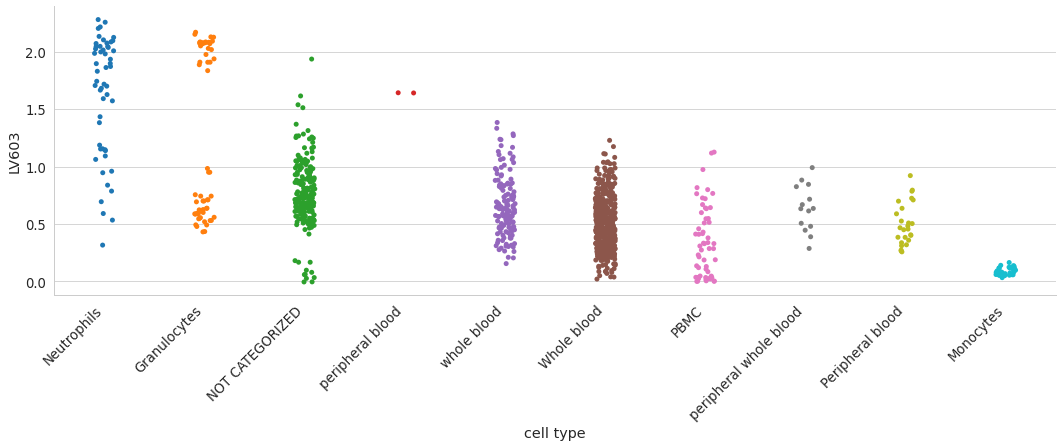

In [37]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTES[0],
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    # You can save the figure if you uncomment the code below
    # the figure will be created under ${DATA_FOLDER}/results/demo

#     plt.savefig(
#         OUTPUT_CELL_TYPE_FILEPATH,
#         bbox_inches="tight",
#         facecolor="white",
#     )

# Debug

Now that you have the figure for your LV, you can debug some things.
For example, you'll see above that some samples are "NOT CATEGORIZED".
Let's see which are those:

In [38]:
with pd.option_context(
    "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
):
    _tmp = final_plot_data[
        final_plot_data[SELECTED_ATTRIBUTES[0]].str.contains("NOT CAT")
    ]
    display(_tmp.head(20))

cell type     LV603
project   run                                  
SRP015360 SRR553460   NOT CATEGORIZED  1.936240
          SRR553463   NOT CATEGORIZED  1.614990
          SRR553461   NOT CATEGORIZED  1.538253
SRP051848 SRR1747386  NOT CATEGORIZED  1.512612
SRP015360 SRR553464   NOT CATEGORIZED  1.368832
SRP051848 SRR1747242  NOT CATEGORIZED  1.313651
          SRR1747230  NOT CATEGORIZED  1.283074
SRP017138 SRR616078   NOT CATEGORIZED  1.267509
SRP051848 SRR1747372  NOT CATEGORIZED  1.266037
          SRR1747348  NOT CATEGORIZED  1.257565
          SRR1747322  NOT CATEGORIZED  1.253071
          SRR1747312  NOT CATEGORIZED  1.247533
          SRR1747314  NOT CATEGORIZED  1.241307
          SRR1747248  NOT CATEGORIZED  1.211017
          SRR1747264  NOT CATEGORIZED  1.169013
          SRR1747304  NOT CATEGORIZED  1.164252
          SRR1747275  NOT CATEGORIZED  1.160602
          SRR1747247  NOT CATEGORIZED  1.129323
          SRR1747321  NOT CATEGORIZED  1.116180
          SRR1747232  NOT CATEGORIZED  1.098986

We don't have information about cell type/tissue for these.
But we can manually go to the URL showed before and check out.
For example, for `SRP015360` we can open our browser with this URL:
https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP015360, and see that the samples were taken from neutrophils.

If you need to see which information is provided by each SRP, you can again use the code below:

In [39]:
# what is there in these projects?
lv_data.loc[["SRP015360"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).head(60)

age   Sex                                   treatment  \
project   run                                                               
SRP015360 SRR553460  30  male                                        none   
          SRR553463  58  male                                        none   
          SRR553461  30  male  incubated for 1h with TNF-alpha (10 ng/mL)   
          SRR553464  58  male  incubated for 1h with TNF-alpha (10 ng/mL)   
          SRR553462  30  male      incubated for 1h with GM-CSF (5 ng/mL)   
          SRR553465  58  male      incubated for 1h with GM-CSF (5 ng/mL)   

                        LV603  
project   run                  
SRP015360 SRR553460  1.936240  
          SRR553463  1.614990  
          SRR553461  1.538253  
          SRR553464  1.368832  
          SRR553462  1.016750  
          SRR553465  0.798007

Now you can go back to section `Standardize cell type names` in this notebook and adjust according to this findings to improve the figure.
Once you are happy, you can remove the `NOT CATEGORIZED` items by uncommenting the code in `Delete samples with no tissue/cell type information`.